In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

np.random.seed(42) # nothing special about this seed (we hope)!

In [2]:
import bnpregcluster_runjingdev.regression_mixture_lib as gmm_lib

In [3]:
reg_params = dict()
with np.load('fits/transformed_gene_regression_df7_degree3_genes1000.npz') as infile:
    reg_params['beta_mean'] = infile['transformed_beta_mean']
    reg_params['beta_info'] = infile['transformed_beta_info']
    
obs_dim = reg_params['beta_mean'].shape[1]
print(reg_params['beta_info'].shape, reg_params['beta_mean'].shape)

(700, 9, 9) (700, 9)


In [4]:
num_components = 15
prior_params = gmm_lib.get_base_prior_params(obs_dim, num_components)
gmm = gmm_lib.GMM(num_components, prior_params, reg_params)

In [5]:
print('Running k-means init.')
kmeans_params = \
    gmm_lib.kmeans_init(gmm.reg_params,
                        gmm.num_components, 50)
print('Done.')
init_gmm_params = dict()
init_gmm_params['centroids'] = kmeans_params['centroids']
init_gmm_params['stick_propn_mean'] = np.zeros(gmm.num_components - 1)
init_gmm_params['stick_propn_info'] = np.ones(gmm.num_components - 1)

init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


In [6]:
gmm.get_params_kl(init_gmm_params)

-102690.17446040658

In [7]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -102690.17446041
Iter 1: f = -103400.79109288
Iter 2: f = -103839.12150699
Iter 3: f = -103918.46093866
Iter 4: f = -103946.65557973
Iter 5: f = -104076.05174664
Iter 6: f = -104146.71784614
Iter 7: f = -104210.68975016
Iter 8: f = -104257.25175798
Iter 9: f = -104283.12166629
Iter 10: f = -104292.18779044
Iter 11: f = -104292.36656490
Iter 12: f = -104294.47466154
Iter 13: f = -104294.81574869
Iter 14: f = -104294.83108552
Iter 15: f = -104294.83111807
Iter 16: f = -104294.83117360


In [8]:
tic = time.time()
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

In [9]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Preconditioned iteration 1
  Running preconditioned optimization.
Iter 0: f = -104294.83117360
Iter 1: f = -104294.83117361
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Running preconditioned optimization.
Iter 2: f = -104294.83117361
Converged.
Optimization time: 5.572522163391113 seconds


In [13]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
e_z = gmm.get_e_z(opt_gmm_params)
print(np.mean(e_z, axis=0))

odict_keys(['centroids', 'stick_propn_mean', 'stick_propn_info'])
[0.28564382 0.14482711 0.108381   0.31644752 0.14470055]


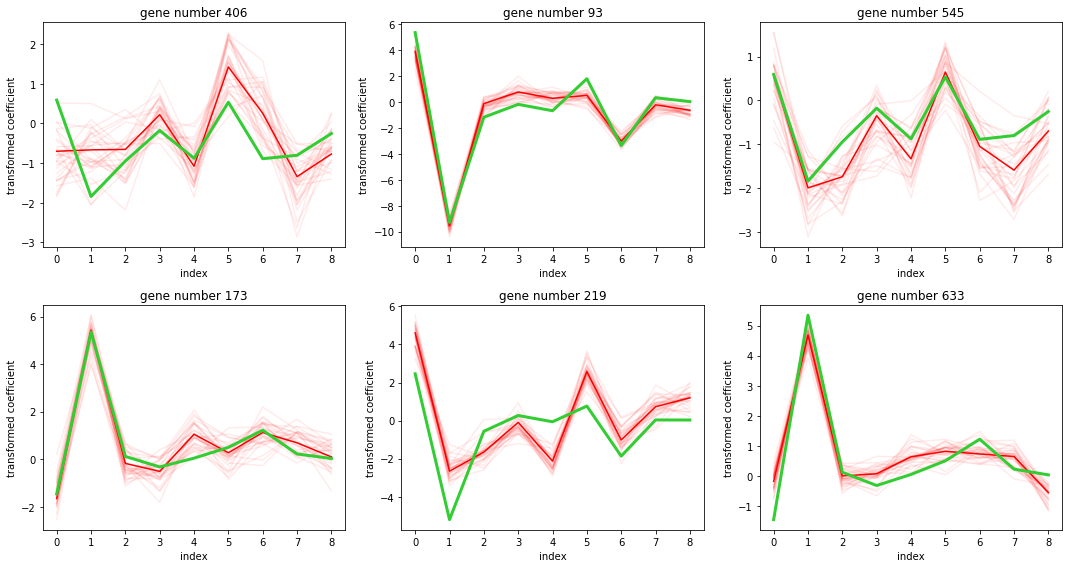

In [18]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

plot_inds = np.random.choice(gmm.num_obs, 6, replace=False)
for i in range(6):
    n = plot_inds[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(gmm.reg_params['beta_mean'][n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            gmm.reg_params['beta_mean'][n, :], \
             np.linalg.inv(gmm.reg_params['beta_info'][n, :, :]))

        axarr[int(np.floor(i / 3)), i % 3].plot(
            transformed_beta_draw, color = 'red', alpha = 0.08);

    k = np.argmax(e_z[n, :])
    this_plot.plot(opt_gmm_params['centroids'][k, :], color = 'limegreen', linewidth=3);

f.tight_layout()